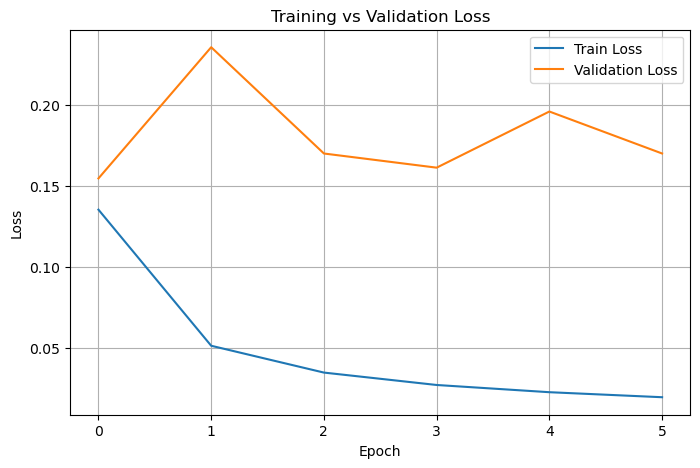

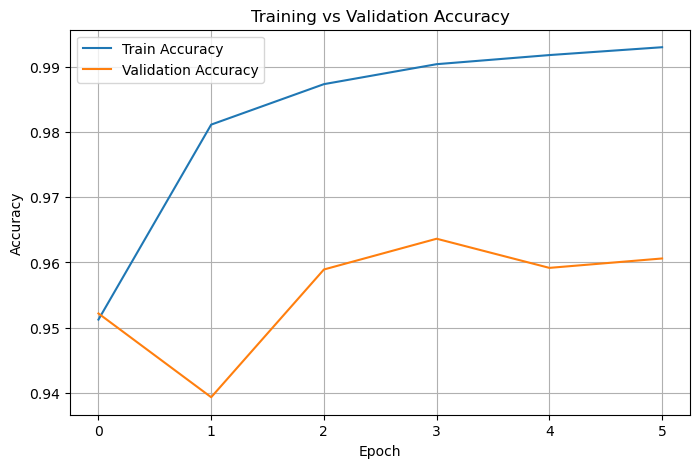

In [1]:
import pickle
import matplotlib.pyplot as plt

# Load training history
with open("./3dcnn_convlstm2d_Wmodels/2cams/training_history-patience5.pkl", "rb") as f:
    history = pickle.load(f)

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import os
import json
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import random
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
# =======================
# Dataset preparation
# =======================
# List of multiple camera roots (add/remove as needed)
FRAMES_ROOTS = [
    "./cam2-resized_frames",
    "./cam3-resized_frames",
]
LABELS_ROOT = "./micro_activity_output"
SEQUENCE_LENGTH = 16

# Keywords for class detection
FALL_KEYWORDS = ["fall_"]
LYING_KEYWORDS = ["lying_", "_lying"]

with open("./f_seq_r_3dcnn-convlstm2d-2cams.pkl", "rb") as f:
    dataset = pickle.load(f)
#just for test
#dataset = dataset[:10]
print(f"Loaded dataset with {len(dataset)} sequences.")

adl_count = sum(1 for _, label in dataset if label == 0)
fall_count = sum(1 for _, label in dataset if label == 1)
lying_count = sum(1 for _, label in dataset if label == 2)

print(f"Total sequences: {len(dataset)}")
print(f"ADL sequences: {adl_count}")
print(f"Fall sequences: {fall_count}")
print(f"Lie Down sequences: {lying_count}")

# =======================
# Actor-based split
# =======================

actor_to_samples = {}
for seq_paths, label in dataset:
    parts = seq_paths[0].split(os.sep)
    actor_folder = next(p for p in parts if p.startswith("Actor_"))
    actor_id = "_".join(actor_folder.split("_")[:2])
    actor_to_samples.setdefault(actor_id, []).append((seq_paths, label))

all_actors = list(actor_to_samples.keys())
random.shuffle(all_actors)
split_idx = int(0.8 * len(all_actors))
train_actors, val_actors = all_actors[:split_idx], all_actors[split_idx:]

train_samples = [s for a in train_actors for s in actor_to_samples[a]]
val_samples = [s for a in val_actors for s in actor_to_samples[a]]

print(f"Actors: {len(all_actors)}, Train actors: {len(train_actors)}, Val actors: {len(val_actors)}")
print(f"Train sequences: {len(train_samples)}, Val sequences: {len(val_samples)}")

'''
split_idx = int(0.8 * len(dataset))
train_samples = dataset[:split_idx]
val_samples = dataset[split_idx:]
'''

# =======================
# Dataset Class
# =======================
class FallSequenceDataset(Dataset):
    def __init__(self, sequence_label_list, transform=None):
        self.data = sequence_label_list
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
        ])
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        frame_paths, label = self.data[idx]
        frames = []
        for path in frame_paths:
            img = Image.open(path).convert("RGB")
            img = self.transform(img)
            frames.append(img)
        frames_tensor = torch.stack(frames).permute(1,0,2,3)  # [C,T,H,W]
        return frames_tensor, torch.tensor(label, dtype=torch.long)

train_dataset = FallSequenceDataset(train_samples)
val_dataset = FallSequenceDataset(val_samples)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

# =======================
# Model: 3D CNN + ConvLSTM2D
# =======================
from convlstm import ConvLSTM

class FallDetector3D(nn.Module):
    def __init__(self, num_classes=3):
        super(FallDetector3D, self).__init__()
        self.conv3d = nn.Sequential(
            nn.Conv3d(3, 96, kernel_size=(3,3,3), stride=1, padding=1),
            nn.BatchNorm3d(96),
            nn.ReLU(),
            nn.MaxPool3d((1,2,2)),

            nn.Conv3d(96, 192, kernel_size=(3,3,3), stride=1, padding=1),
            nn.BatchNorm3d(192),
            nn.ReLU(),
            nn.MaxPool3d((2,2,2)),

            nn.Conv3d(192, 384, kernel_size=(3,3,3), stride=1, padding=1),
            nn.BatchNorm3d(384),
            nn.ReLU(),
            nn.MaxPool3d((2,2,2))
        )
        self.convlstm = ConvLSTM(input_dim=384,
                                 hidden_dim=384,
                                 kernel_size=(3,3),
                                 num_layers=2,
                                 batch_first=True,
                                 bias=True,
                                 return_all_layers=False)
        self.pool = nn.AdaptiveAvgPool2d((7,7))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(384*7*7, num_classes)

    def forward(self, x):
        feat3d = self.conv3d(x)               # [B,384,T,H,W]
        B, C, T, H, W = feat3d.shape
        feat3d = feat3d.permute(0,2,1,3,4)    # [B,T,C,H,W]
        out, _ = self.convlstm(feat3d)
        last_out = out[0][:,-1]               # [B,C,H,W]
        pooled = self.pool(last_out)          # [B,C,7,7]
        flat = pooled.view(B, -1)
        flat = self.dropout(flat)
        return self.fc(flat)


Loaded dataset with 702093 sequences.
Total sequences: 702093
ADL sequences: 591614
Fall sequences: 43913
Lie Down sequences: 66566
Actors: 8, Train actors: 6, Val actors: 2
Train sequences: 507397, Val sequences: 194696


In [3]:
#load model
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

model = FallDetector3D(num_classes=3).to(device)
model.load_state_dict(torch.load("./3dcnn_convlstm2d_Wmodels/2cams/fall_3dcnn_convlstm2d_final-patience5.pth", map_location=device))
model.eval()


FallDetector3D(
  (conv3d): Sequential(
    (0): Conv3d(3, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(96, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(192, 384, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0-1): 2 x ConvLSTMCell(

In [4]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 23791299
Trainable parameters: 23791299


In [7]:
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch

# same transforms used during training
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # only if you trained with 224x224
    transforms.ToTensor()
])

class_names = ["ADL", "Fall", "Lie Down"]

def predict_sequence(frame_paths):
    frames = []
    for path in frame_paths:
        img = Image.open(path).convert("RGB")
        img = transform(img)
        frames.append(img)

    # convert to [1,C,T,H,W] for 3D CNN
    frames_tensor = torch.stack(frames)  # [T,C,H,W]
    frames_tensor = frames_tensor.permute(1,0,2,3).unsqueeze(0).to(device)  # [1,C,T,H,W]

    with torch.no_grad():
        outputs = model(frames_tensor)
        _, pred = torch.max(outputs, 1)

    predicted_class = class_names[pred.item()]
    print(f"Predicted class: {predicted_class}")

    # show 16 frames
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        frame = frames[i].permute(1, 2, 0).numpy()  # [C,H,W] -> [H,W,C]
        ax.imshow(frame)
        ax.axis("off")
    plt.suptitle(f"Predicted: {predicted_class}", fontsize=16)
    plt.tight_layout()
    plt.show()

Predicted class: ADL


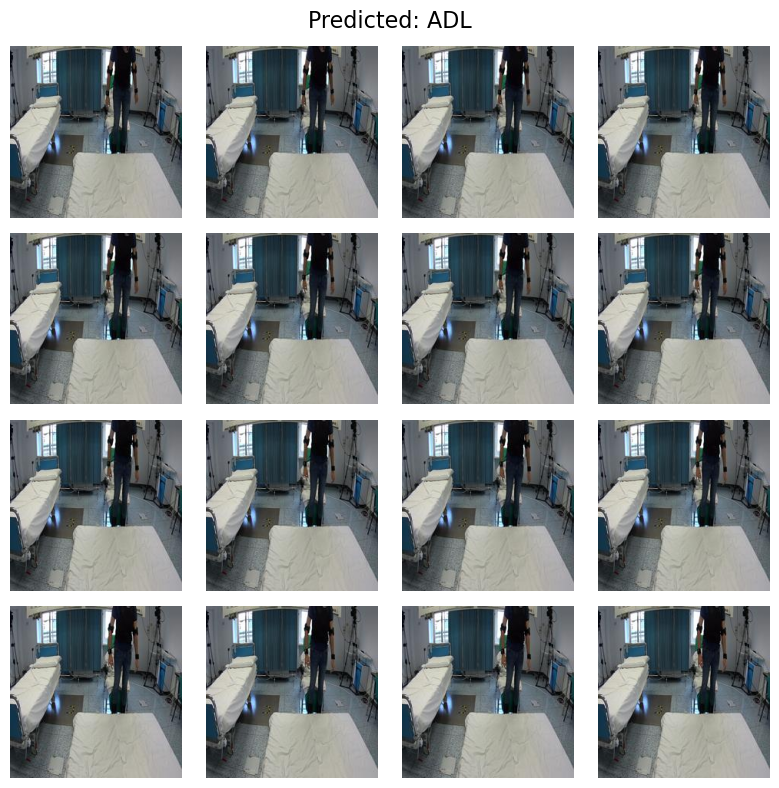

In [16]:
sample_seq = val_samples[82370][0]
predict_sequence(sample_seq)

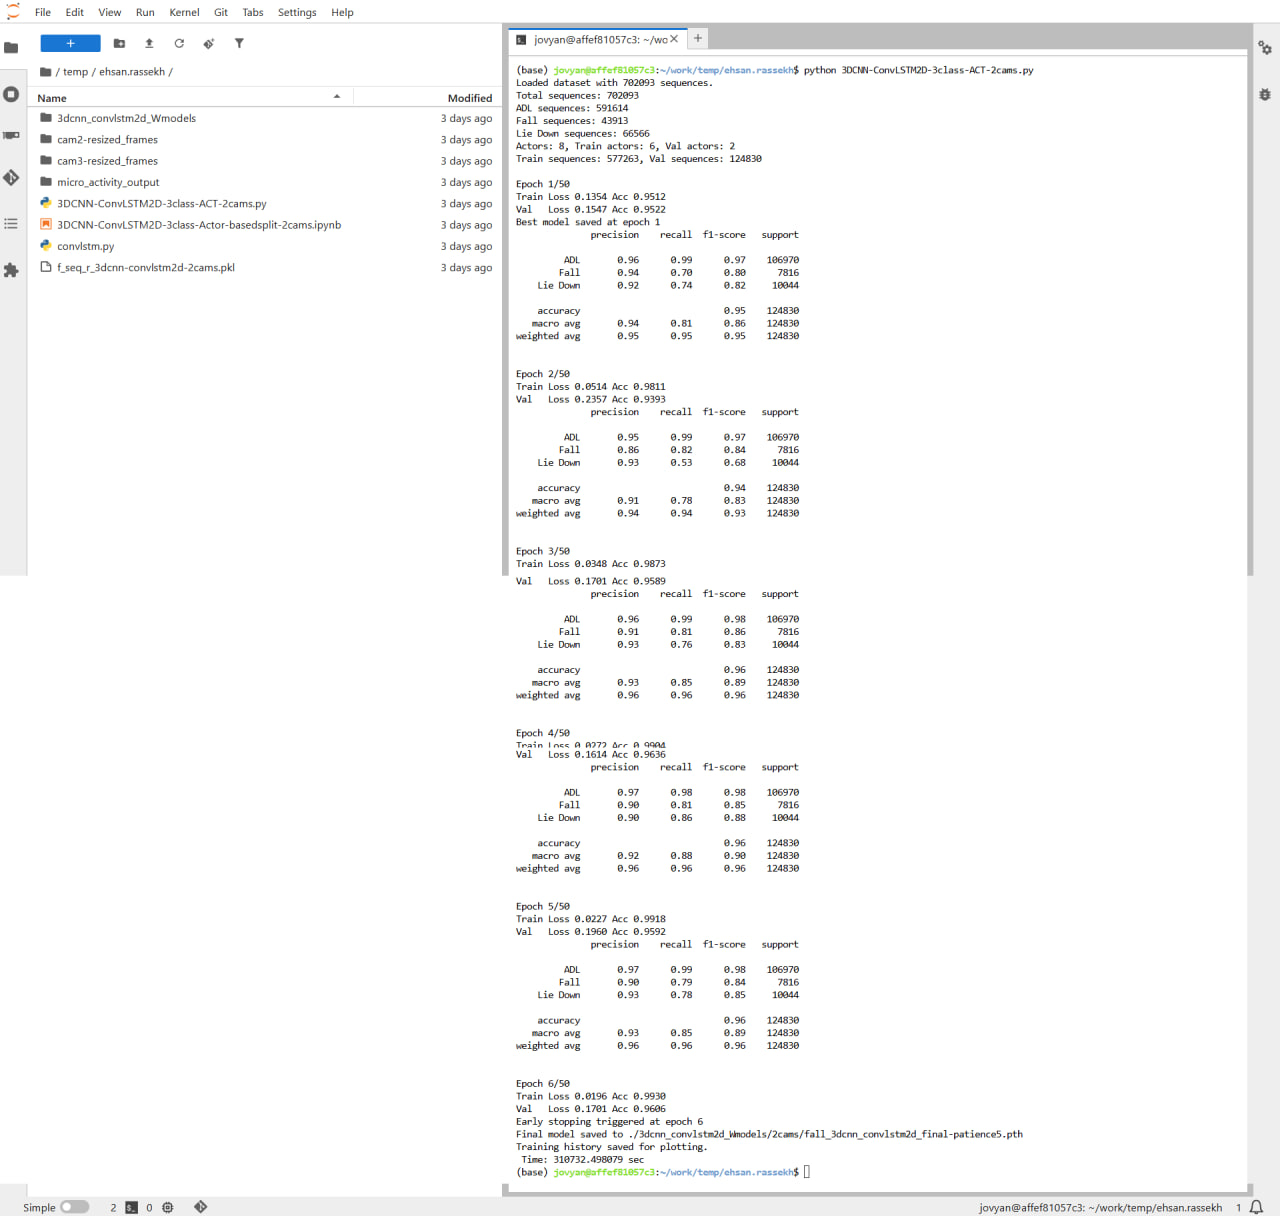

3 days, 14 hours, 18 minutes, and 52.498 seconds

Validation Accuracy (Best Model): 0.9954

Classification Report:
               precision    recall  f1-score   support

         ADL       1.00      1.00      1.00    168948
        Fall       0.99      0.98      0.98     13158
    Lie Down       0.98      0.98      0.98     12590

    accuracy                           1.00    194696
   macro avg       0.99      0.99      0.99    194696
weighted avg       1.00      1.00      1.00    194696



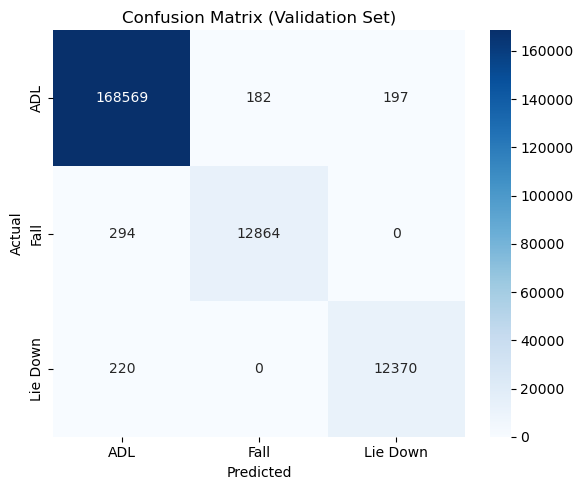

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# total Accuracy
print(f"Validation Accuracy (Best Model): {correct / total:.4f}")

# Classification Report
class_names = ["ADL", "Fall", "Lie Down"]
report = classification_report(all_labels, all_preds, target_names=class_names, digits=2)
print("\nClassification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()